In [1]:
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb

from IPython.display import display

# 正解率
from sklearn.metrics import accuracy_score

# 適合率
from sklearn.metrics import precision_score

# 再現率
from sklearn.metrics import recall_score

# f1_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

# DataFrameの表示数を変更
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(3))
display(train.tail(3))
display(train.shape)
display(train.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
847,50,Male,0.826785,0.138898,230.340081,40.495102,49.620857,7.529840,3.724408,0.987033,1
848,32,Female,0.761972,0.137969,214.170393,18.048321,54.447774,5.944855,3.150978,1.220787,0
849,64,Male,0.762713,0.218435,214.720510,15.885571,24.789606,6.768439,3.686097,1.309895,0


(850, 11)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease       int64
dtype: object

In [4]:
display(test.head(3))
display(test.tail(3))
display(test.shape)
display(test.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
347,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256
348,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348
349,57,Male,0.869632,0.236444,367.364415,23.534291,48.729618,7.537565,3.629533,1.285716


(350, 10)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
dtype: object

0	id	int	インデックスとして使用  
1	Age	int	年齢  
2	Gender	char	性別  
3	T_Bil	float	検査項目1： 総ビリルビン (Total Bilirubin)  
4	D_Bil	float	検査項目2： 直接ビリルビン (Direct Bilirubin)  
5	ALP	float	検査項目3： アルカリフォスファター ゼ (Alkaline Phosphotase)  
6	ALT_GPT	float	検査項目4： アラニンアミノトランスフェラーゼ (Alanine Transaminase)  
7	AST_GOT	float	検査項目5： アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase)  
8	TP	float	検査項目6： 総タンパク (Total Protiens)  
9	Alb	float	検査項目7： アルブミン (Albumin)  
10	AG_ratio	float	検査項目8： アルブミン/グロブリン比  
11	disease	int	肝疾患の有無（0:無, 1:有）  

In [5]:
# 相関係数
train.corr()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.000000,-0.001248,-0.014136,-0.023907,-0.037906,-0.008589,-0.037754,-0.087120,-0.033220,0.024216
T_Bil,-0.001248,1.000000,0.753227,0.148064,0.219784,0.248709,-0.060230,-0.162017,-0.206122,0.357653
D_Bil,-0.014136,0.753227,1.000000,0.091924,0.184403,0.201485,0.017750,-0.089132,-0.121481,0.282316
ALP,-0.023907,0.148064,0.091924,1.000000,-0.021187,0.019047,0.025728,-0.023041,-0.159614,0.211950
ALT_GPT,-0.037906,0.219784,0.184403,-0.021187,1.000000,0.655518,-0.100572,-0.087652,0.005806,0.199239
AST_GOT,-0.008589,0.248709,0.201485,0.019047,0.655518,1.000000,-0.071592,-0.086669,-0.022277,0.316456
TP,-0.037754,-0.060230,0.017750,0.025728,-0.100572,-0.071592,1.000000,0.727319,0.270246,-0.073766
Alb,-0.087120,-0.162017,-0.089132,-0.023041,-0.087652,-0.086669,0.727319,1.000000,0.607400,-0.176602
AG_ratio,-0.033220,-0.206122,-0.121481,-0.159614,0.005806,-0.022277,0.270246,0.607400,1.000000,-0.307895
disease,0.024216,0.357653,0.282316,0.211950,0.199239,0.316456,-0.073766,-0.176602,-0.307895,1.000000


<AxesSubplot:>

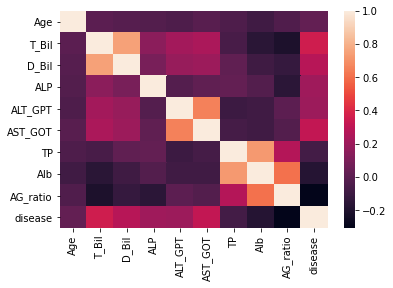

In [6]:
sns.heatmap(train.corr())

### 外れ値処理

In [7]:
num_list = list(test.select_dtypes(exclude=object).columns)
num_list

['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

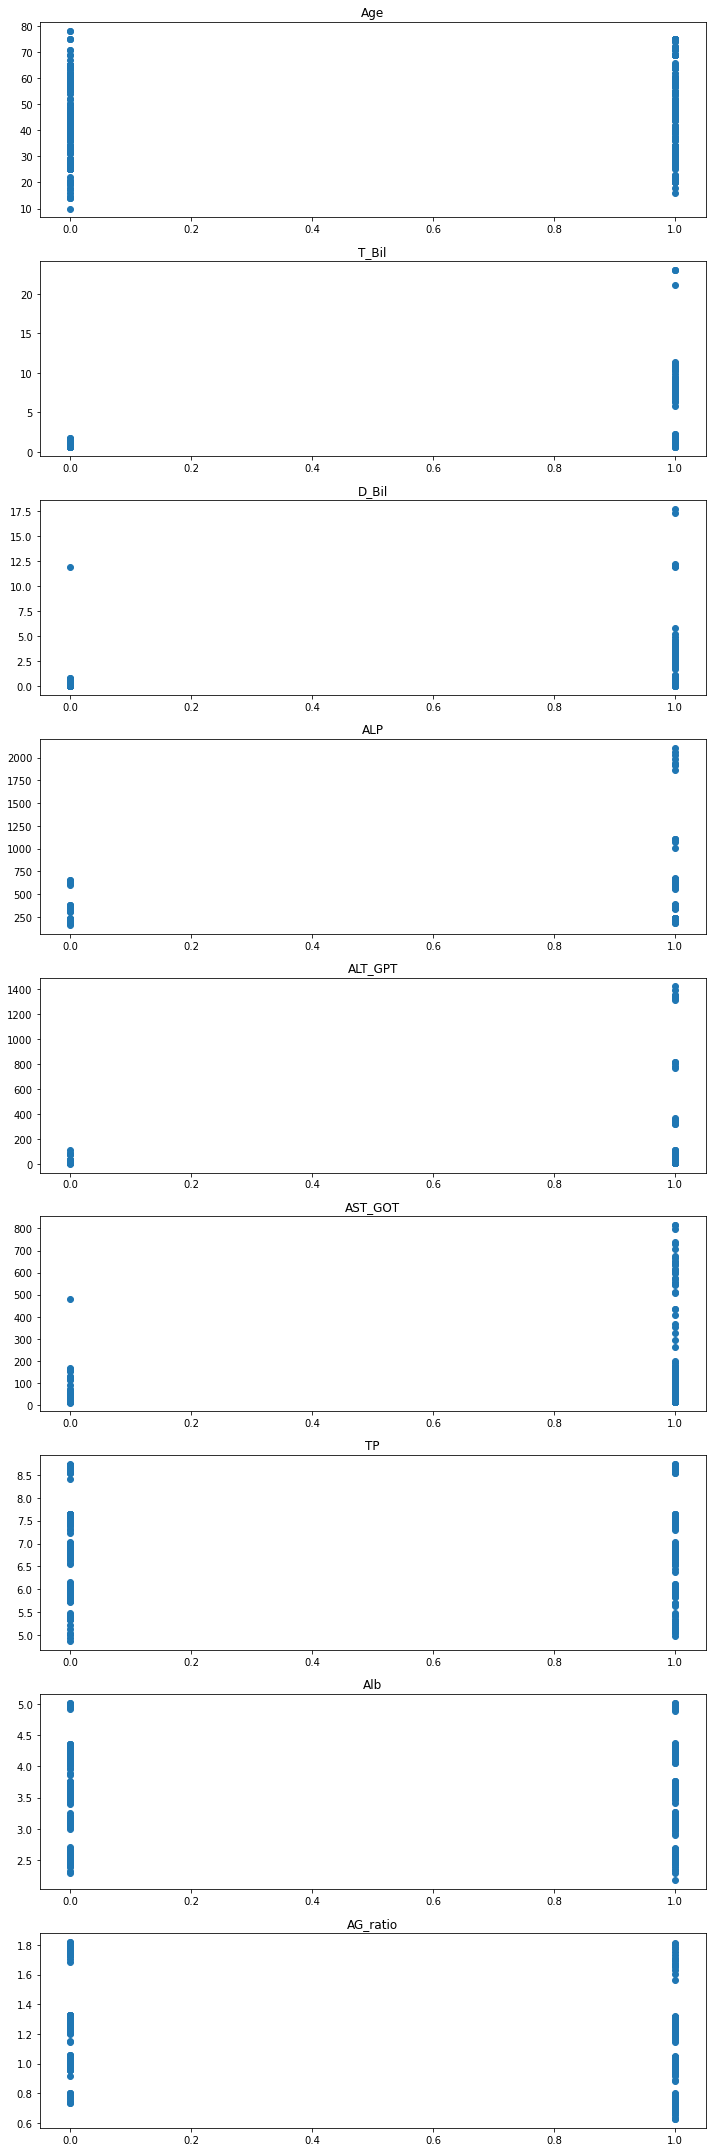

In [8]:
# diseaseごとの各カラムの散布図を見て外れ値を探す

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train['disease'], train[num_list[i]])

plt.tight_layout()

In [9]:
# Age 削除対象
display(train[(train['Age']>75) & (train['disease']==0)])
display(train[(train['Age']<12) & (train['disease']==0)])

train = train.drop(train[(train['Age']>75) & (train['disease']==0)].index)
train = train.drop(train[(train['Age']<12) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
268,78,Male,0.810486,0.197167,213.961347,15.247348,20.931720,7.530853,3.634814,1.285051,0
475,78,Male,0.717658,0.164531,207.302298,9.473956,21.145924,6.864853,3.600574,1.311394,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
402,10,Male,0.767137,0.173513,214.651243,13.132598,20.931029,7.536683,4.212869,1.288729,0


In [10]:
# T-Bil 削除対象
display(train[train['T_Bil']>15])

# 削除
train = train.drop(train[train['T_Bil']>15].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
69,26,Male,23.017027,11.992452,214.777736,12.921732,98.892019,7.595521,3.585702,0.987575,1
240,50,Female,21.184706,17.264120,214.413921,16.616958,28.436753,8.639342,3.089583,1.225404,1
297,32,Male,23.013928,17.692164,206.635298,10.197751,22.378512,5.844967,3.136777,1.184554,1
468,32,Male,23.002653,11.978404,1861.148040,23.111268,62.911839,6.882093,3.203098,0.913798,1


In [11]:
# D-Bil 削除対象
display(train[train['D_Bil']>10])

train = train.drop(train[train['D_Bil']>10].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
119,47,Male,0.874862,12.140346,212.041216,44.877908,104.234557,8.612374,3.520750,1.215675,1
130,42,Male,0.930668,11.935322,197.000997,10.514899,14.825766,7.581402,3.659571,1.024392,0
363,59,Male,0.972024,11.908908,217.020581,13.980081,59.748856,8.661666,3.663260,1.289892,1
766,65,Male,0.858532,12.033170,220.387128,17.155909,80.863658,7.629307,4.123316,1.184591,1
826,32,Male,0.983627,12.201824,218.317890,10.606974,75.159134,7.602828,3.685454,0.987741,1


In [12]:
# AST-GOT 削除対象
display(train[(train['AST_GOT']>400) & (train['disease']==0)])

train = train.drop(train[(train['AST_GOT']>400) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
662,75,Male,1.465158,0.767795,366.834104,116.407037,481.935324,8.631458,4.337368,1.262153,0


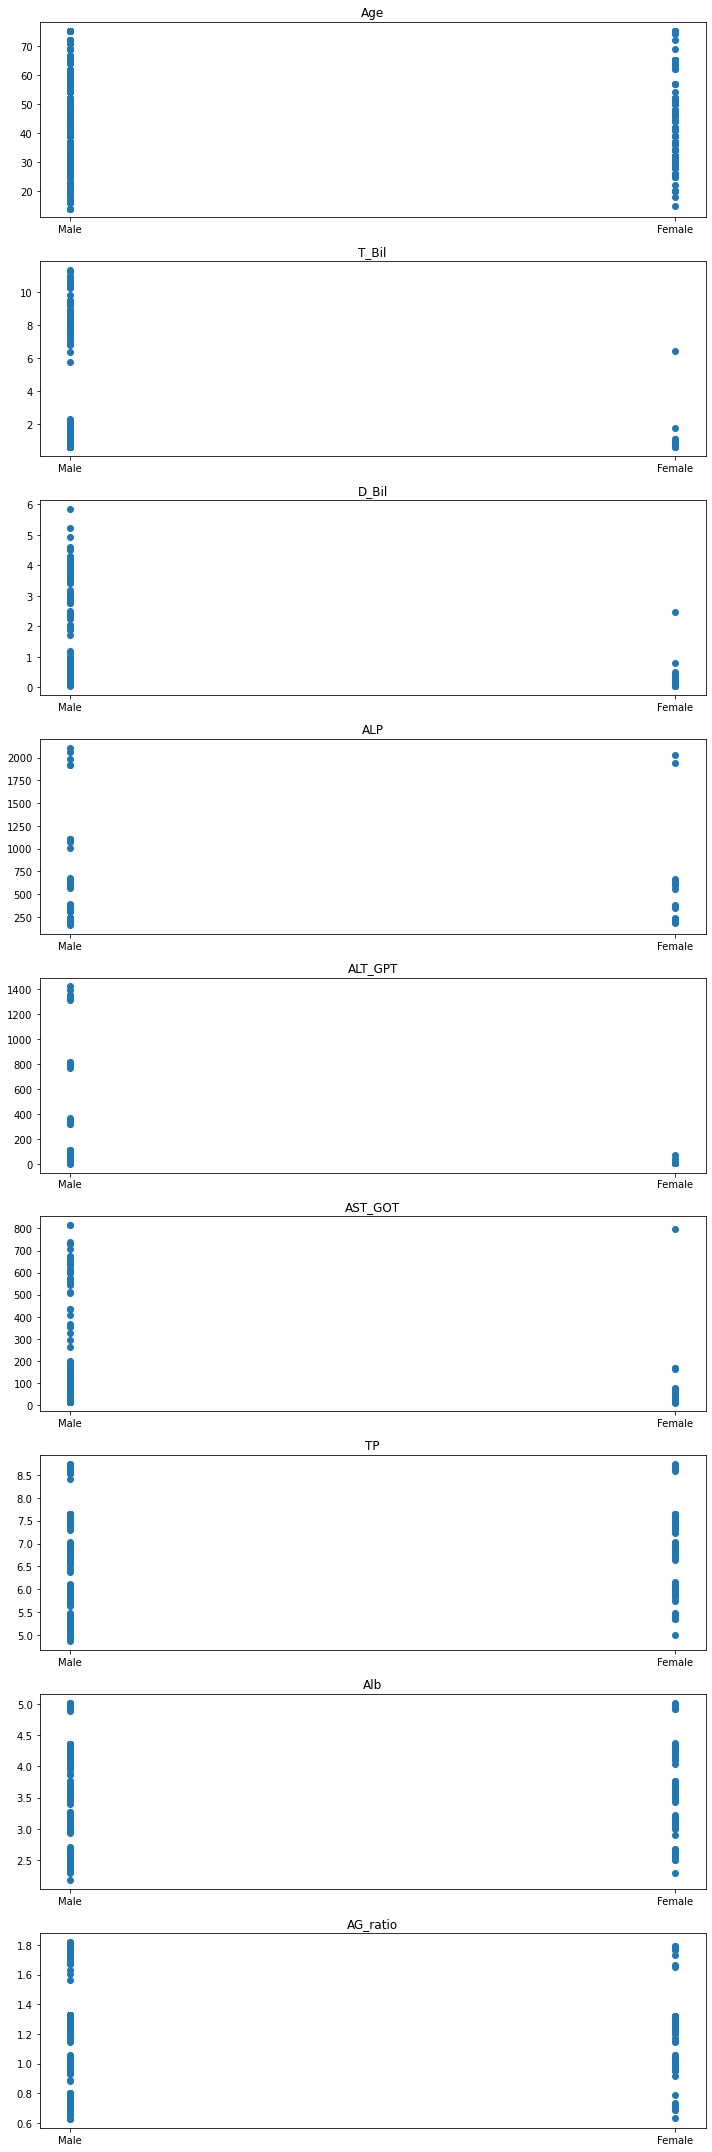

In [13]:
# Genderごとの各カラムの散布図を見て外れ値を探す

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train['Gender'], train[num_list[i]])

plt.tight_layout()

In [14]:
# T-Bil 削除対象
display(train[(train['T_Bil']>5) & (train['Gender']=="Female")])

train = train.drop(train[(train['T_Bil']>5) & (train['Gender']=="Female")].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
715,75,Female,6.439106,2.458748,637.030089,24.12591,67.788687,6.037188,3.1055,1.021437,1


In [15]:
# D-Bil 削除対象
display(train[(train['D_Bil']>1) & (train['Gender']=="Female")])

train = train.drop(train[(train['D_Bil']>1) & (train['Gender']=="Female")].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease


In [16]:
# AST_GOT 削除対象
display(train[(train['AST_GOT']>150) & (train['Gender']=="Female")])

train = train.drop(train[(train['AST_GOT']>150) & (train['Gender']=="Female")].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0
37,26,Female,0.936711,0.157125,201.977549,29.518400,169.029000,6.960239,2.901342,1.264539,1
88,34,Female,0.710537,0.055281,192.260651,71.357581,164.134919,6.918934,3.558867,1.279367,0
481,75,Female,0.960339,0.284536,207.307424,33.103655,797.829706,6.898645,3.624944,1.268522,1


### カテゴリデータの可視化

<AxesSubplot:title={'center':'train Gender'}, xlabel='Gender'>

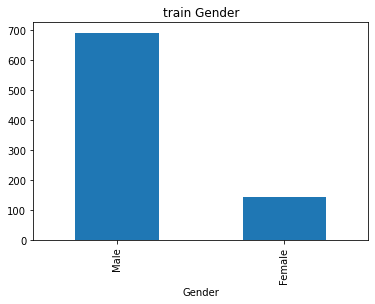

In [17]:
train.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="train Gender")

<AxesSubplot:title={'center':'test Gender'}, xlabel='Gender'>

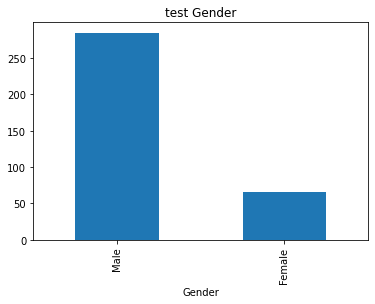

In [18]:
test.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="test Gender")

### 欠損値処理

In [19]:
display(train.isnull().sum())
display(test.isnull().sum())

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64

### ラベルエンコーディング

In [20]:
lbl = preprocessing.LabelEncoder()

In [21]:
train["Gender"] = lbl.fit_transform(train["Gender"])
test["Gender"] = lbl.fit_transform(test["Gender"])

### 特徴量選択

In [22]:
features = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### Filter Method

In [23]:
train.corr()["disease"]

Age         0.025275
Gender      0.113480
T_Bil       0.390291
D_Bil       0.383841
ALP         0.212064
ALT_GPT     0.203443
AST_GOT     0.326141
TP         -0.079979
Alb        -0.174318
AG_ratio   -0.310132
disease     1.000000
Name: disease, dtype: float64

In [24]:
# D_Bil	T_Bil 0.930493

# disease T_Bil 0.390951
# disease D_Bil 0.384931 -> こちらを削除
train.corr()[abs(train.corr()) > 0.8]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_Bil,NaN,NaN,1.000000,0.930068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D_Bil,NaN,NaN,0.930068,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ALT_GPT,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
AST_GOT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Alb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
AG_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [25]:
features = ['Age', 'Gender', 'T_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### データの分割

In [26]:
# testデータに復元用のNo.を振る
serial_num = pd.RangeIndex(start=1, stop=test.shape[0]+1, step=1)
test['No'] = serial_num

In [27]:
# 男性データ
train_M = train[train["Gender"] == 1]
test_M = test[test["Gender"] == 1]

# 女性データ
train_F = train[train["Gender"] == 0]
test_F = test[test["Gender"] == 0]

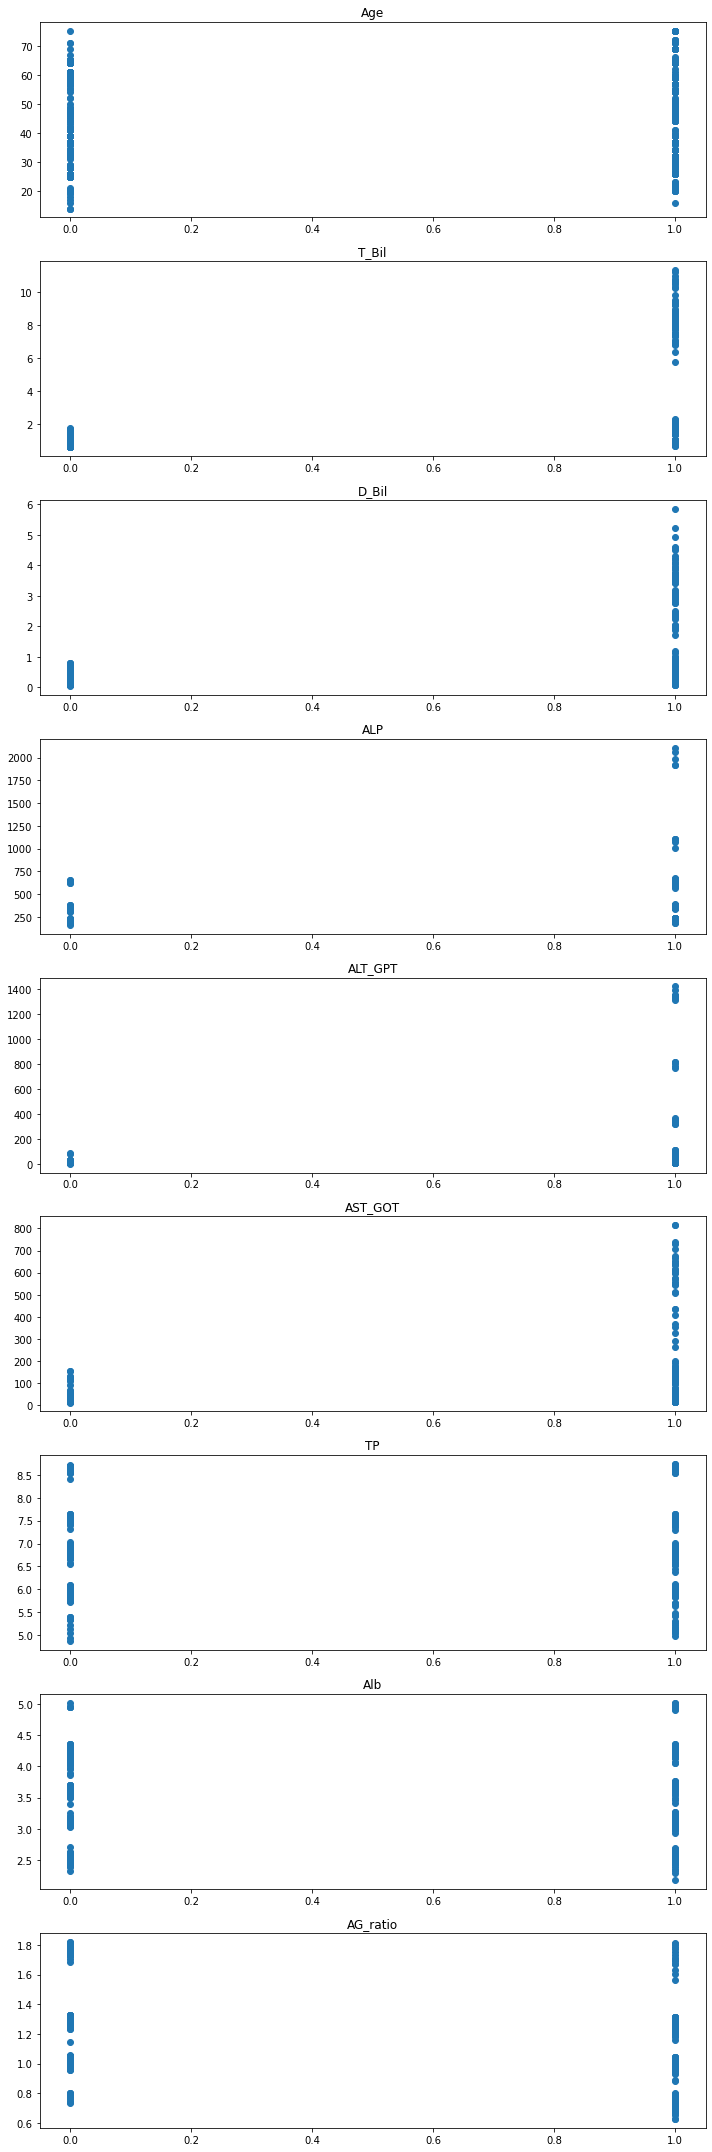

In [28]:
# 男性データ

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train_M['disease'], train_M[num_list[i]])

plt.tight_layout()

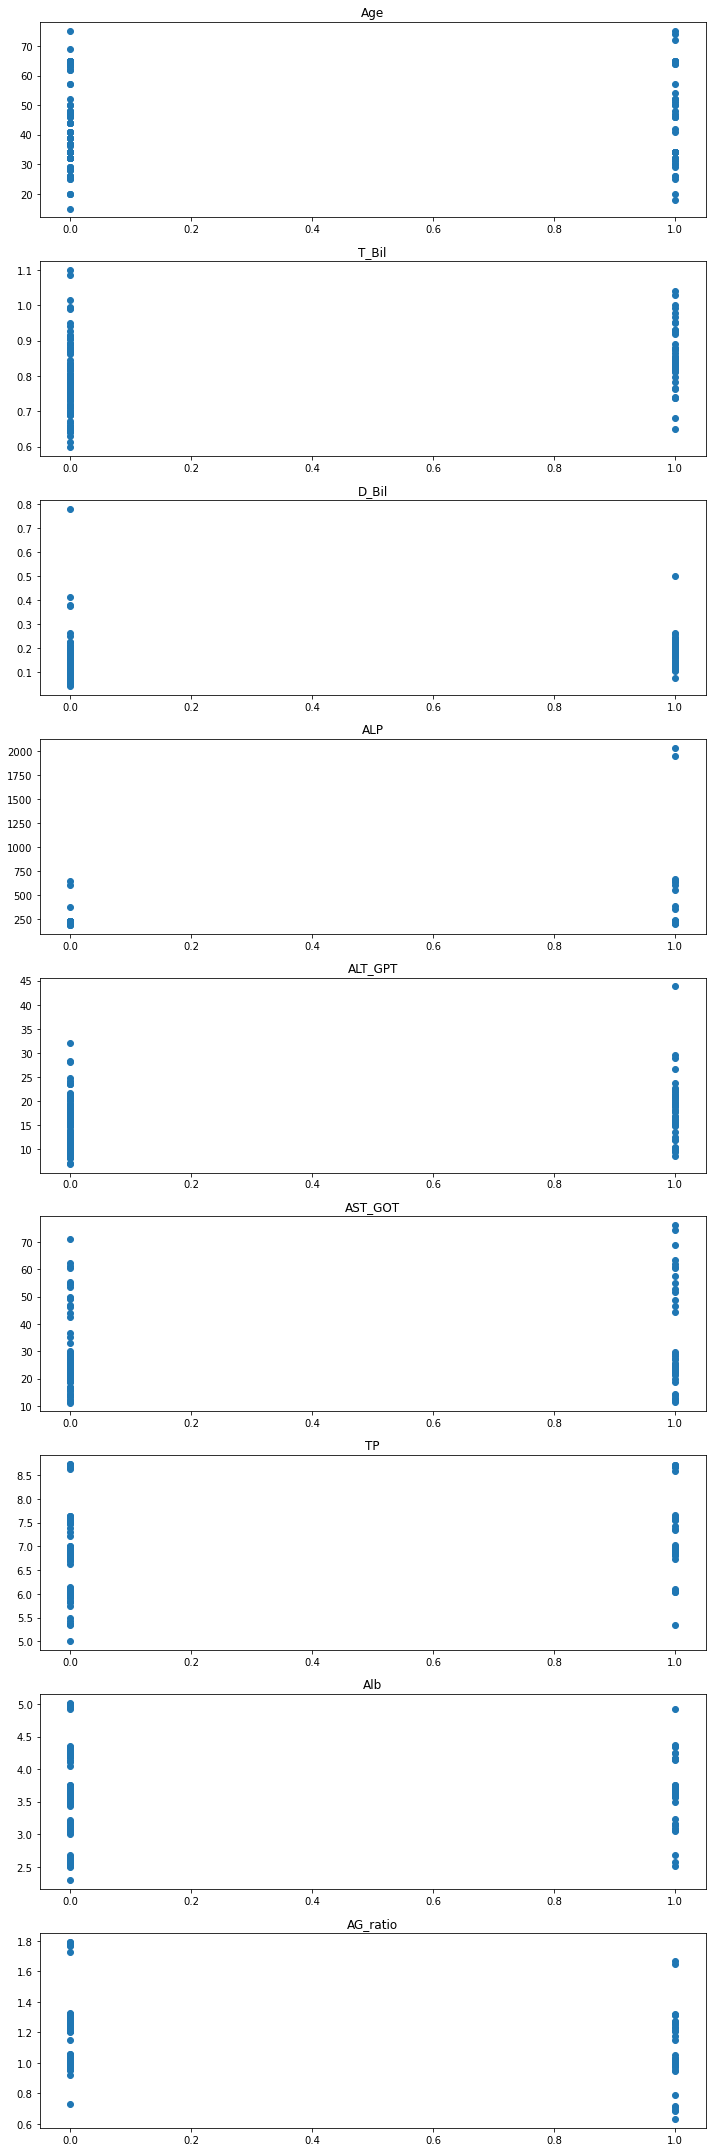

In [29]:
# 女性データ

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train_F['disease'], train_F[num_list[i]])

plt.tight_layout()

In [30]:
# D-Bil 削除対象
display(train_F[(train['D_Bil']>0.3) & (train['disease']==0)])

train_F = train_F.drop(train_F[(train['D_Bil']>0.3) & (train['disease']==0)].index)

display(train_F[(train['D_Bil']>0.4) & (train['disease']==1)])

train_F = train_F.drop(train_F[(train['D_Bil']>0.4) & (train['disease']==1)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
245,34,0,0.779795,0.778945,199.738489,7.030325,22.454672,7.296740,3.543444,1.323986,0
463,29,0,0.640436,0.414276,227.812485,24.221439,32.898855,6.633787,3.099435,0.959628,0
551,65,0,0.871189,0.375350,213.984334,20.436720,49.749406,7.564694,3.618911,1.251209,0
839,36,0,0.767723,0.380726,230.579746,28.375602,29.227216,5.954977,3.145970,1.251669,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
133,32,0,0.766545,0.498794,230.257096,26.590234,27.378936,6.814849,3.142696,0.995753,1


In [31]:
# ALT_GPT 削除対象
display(train_F[(train['ALT_GPT']>40) & (train['disease']==1)])

train_F = train_F.drop(train_F[(train['ALT_GPT']>40) & (train['disease']==1)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
531,51,0,0.763286,0.188452,2032.29066,43.7834,68.801471,8.593563,3.641546,1.000775,1


In [32]:
# AG_ratio 削除対象
display(train_F[(train['AG_ratio']<0.8) & (train['disease']==0)])

train_F = train_F.drop(train_F[(train['AG_ratio']<0.8) & (train['disease']==0)].index)

display(train_F[(train['AG_ratio']>1.5) & (train['disease']==1)])

train_F = train_F.drop(train_F[(train['AG_ratio']>1.5) & (train['disease']==1)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
742,65,0,0.874874,0.129171,223.130109,9.358009,24.40372,5.84459,2.594056,0.732968,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
122,26,0,0.929387,0.219455,221.638808,18.849006,28.203091,6.733713,4.146694,1.666130,1
147,26,0,1.040998,0.246085,638.268972,21.303000,25.181641,6.889561,4.161659,1.648163,1


### ホールドアウト法

In [33]:
# 男性データ
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(train_M[features], 
                                                    train_M["disease"], test_size=0.3, random_state=42)

In [34]:
# 女性データ
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(train_F[features], 
                                                    train_F["disease"], test_size=0.3, random_state=42)

### 学習

#### lightGBM

In [35]:
# 男性データ
train_set_M = lgb.Dataset(X_train_M, y_train_M)
val_set_M = lgb.Dataset(X_test_M, y_test_M, reference=train_set_M)

In [36]:
# 女性データ
train_set_F = lgb.Dataset(X_train_F, y_train_F)
val_set_F = lgb.Dataset(X_test_F, y_test_F, reference=train_set_F)

In [37]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'verbosity': -1,
    'seed': 42,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75,
}

In [38]:
# 男性用学習モデル
model_lgb_M = lgb.train(params, train_set_M, valid_sets=val_set_M,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


feature_fraction, val_score: 0.958896:  14%|#4        | 1/7 [00:00<00:02,  2.35it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946227
[100]	valid_0's auc: 0.949794
[150]	valid_0's auc: 0.948104
[200]	valid_0's auc: 0.947447
Early stopping, best iteration is:
[131]	valid_0's auc: 0.951014


feature_fraction, val_score: 0.958896:  29%|##8       | 2/7 [00:01<00:02,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95045
[100]	valid_0's auc: 0.951295
Early stopping, best iteration is:
[16]	valid_0's auc: 0.952937


feature_fraction, val_score: 0.958896:  43%|####2     | 3/7 [00:01<00:01,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.948574
[100]	valid_0's auc: 0.951764
Early stopping, best iteration is:
[20]	valid_0's auc: 0.954767


feature_fraction, val_score: 0.958896:  57%|#####7    | 4/7 [00:01<00:01,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951107
[100]	valid_0's auc: 0.95092
[150]	valid_0's auc: 0.957113
[200]	valid_0's auc: 0.954017
[250]	valid_0's auc: 0.954204
Early stopping, best iteration is:
[152]	valid_0's auc: 0.957864


feature_fraction, val_score: 0.958896:  71%|#######1  | 5/7 [00:02<00:00,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951107
[100]	valid_0's auc: 0.95092
[150]	valid_0's auc: 0.957113
[200]	valid_0's auc: 0.954017
[250]	valid_0's auc: 0.954204
Early stopping, best iteration is:
[152]	valid_0's auc: 0.957864


feature_fraction, val_score: 0.958896:  86%|########5 | 6/7 [00:03<00:00,  1.90it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.940128
[100]	valid_0's auc: 0.943131
[150]	valid_0's auc: 0.938626
Early stopping, best iteration is:
[99]	valid_0's auc: 0.943881


num_leaves, val_score: 0.958896:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:   5%|5         | 1/20 [00:00<00:07,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  10%|#         | 2/20 [00:00<00:07,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  15%|#5        | 3/20 [00:01<00:06,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.955424
[100]	valid_0's auc: 0.949137
[150]	valid_0's auc: 0.954392
Early stopping, best iteration is:
[51]	valid_0's auc: 0.956738


num_leaves, val_score: 0.958896:  20%|##        | 4/20 [00:01<00:06,  2.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  25%|##5       | 5/20 [00:02<00:05,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  30%|###       | 6/20 [00:02<00:05,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  35%|###5      | 7/20 [00:02<00:05,  2.42it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  40%|####      | 8/20 [00:03<00:04,  2.41it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  45%|####5     | 9/20 [00:03<00:04,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  50%|#####     | 10/20 [00:04<00:04,  2.29it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  55%|#####5    | 11/20 [00:04<00:03,  2.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  60%|######    | 12/20 [00:05<00:03,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  65%|######5   | 13/20 [00:05<00:03,  2.23it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  70%|#######   | 14/20 [00:06<00:02,  2.10it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  75%|#######5  | 15/20 [00:06<00:02,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  80%|########  | 16/20 [00:07<00:01,  2.04it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  85%|########5 | 17/20 [00:07<00:01,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  90%|######### | 18/20 [00:08<00:00,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


num_leaves, val_score: 0.958896:  95%|#########5| 19/20 [00:08<00:00,  2.06it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956832
[100]	valid_0's auc: 0.952233
Early stopping, best iteration is:
[44]	valid_0's auc: 0.958896


bagging, val_score: 0.958896:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94726
Early stopping, best iteration is:
[29]	valid_0's auc: 0.956738


bagging, val_score: 0.958896:  10%|#         | 1/10 [00:00<00:01,  5.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95167
[100]	valid_0's auc: 0.957207
[150]	valid_0's auc: 0.955049
Early stopping, best iteration is:
[90]	valid_0's auc: 0.959084


bagging, val_score: 0.959084:  20%|##        | 2/10 [00:00<00:02,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.957395
[100]	valid_0's auc: 0.957301
Early stopping, best iteration is:
[38]	valid_0's auc: 0.95899


bagging, val_score: 0.959084:  30%|###       | 3/10 [00:01<00:02,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


bagging, val_score: 0.959929:  40%|####      | 4/10 [00:01<00:02,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95214
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.946978
Early stopping, best iteration is:
[52]	valid_0's auc: 0.95289


bagging, val_score: 0.959929:  50%|#####     | 5/10 [00:02<00:01,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951952
[100]	valid_0's auc: 0.953641
[150]	valid_0's auc: 0.95458
[200]	valid_0's auc: 0.955518
[250]	valid_0's auc: 0.954955
[300]	valid_0's auc: 0.954767
Early stopping, best iteration is:
[215]	valid_0's auc: 0.95702


bagging, val_score: 0.959929:  60%|######    | 6/10 [00:03<00:02,  1.81it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951858
[100]	valid_0's auc: 0.957395
[150]	valid_0's auc: 0.953266
Early stopping, best iteration is:
[94]	valid_0's auc: 0.957676


bagging, val_score: 0.959929:  70%|#######   | 7/10 [00:03<00:01,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.950169
[100]	valid_0's auc: 0.95533
[150]	valid_0's auc: 0.950638
Early stopping, best iteration is:
[91]	valid_0's auc: 0.957676


bagging, val_score: 0.959929:  80%|########  | 8/10 [00:03<00:00,  2.18it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.958146
[100]	valid_0's auc: 0.95655
Early stopping, best iteration is:
[42]	valid_0's auc: 0.95899


bagging, val_score: 0.959929:  90%|######### | 9/10 [00:04<00:00,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.947166
[100]	valid_0's auc: 0.944632
Early stopping, best iteration is:
[41]	valid_0's auc: 0.951577


feature_fraction_stage2, val_score: 0.959929:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


feature_fraction_stage2, val_score: 0.959929:  17%|#6        | 1/6 [00:00<00:01,  4.07it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


feature_fraction_stage2, val_score: 0.959929:  33%|###3      | 2/6 [00:00<00:01,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


feature_fraction_stage2, val_score: 0.959929:  50%|#####     | 3/6 [00:01<00:00,  3.13it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954486
[100]	valid_0's auc: 0.955143
[150]	valid_0's auc: 0.947729
Early stopping, best iteration is:
[70]	valid_0's auc: 0.958615


feature_fraction_stage2, val_score: 0.959929:  67%|######6   | 4/6 [00:01<00:00,  2.97it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


feature_fraction_stage2, val_score: 0.959929:  83%|########3 | 5/6 [00:01<00:00,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954486
[100]	valid_0's auc: 0.955143
[150]	valid_0's auc: 0.947729
Early stopping, best iteration is:
[70]	valid_0's auc: 0.958615


regularization_factors, val_score: 0.959929:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954861
[100]	valid_0's auc: 0.956926
[150]	valid_0's auc: 0.954017
Early stopping, best iteration is:
[88]	valid_0's auc: 0.961618


regularization_factors, val_score: 0.961618:   5%|5         | 1/20 [00:00<00:04,  4.16it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.952797
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


regularization_factors, val_score: 0.961618:  10%|#         | 2/20 [00:00<00:05,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.950544
[100]	valid_0's auc: 0.960116
[150]	valid_0's auc: 0.958052
Early stopping, best iteration is:
[94]	valid_0's auc: 0.962087


regularization_factors, val_score: 0.962087:  15%|#5        | 3/20 [00:01<00:05,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.95289
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


regularization_factors, val_score: 0.962087:  20%|##        | 4/20 [00:01<00:05,  2.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954767
[100]	valid_0's auc: 0.953923
[150]	valid_0's auc: 0.952327
Early stopping, best iteration is:
[69]	valid_0's auc: 0.959459


regularization_factors, val_score: 0.962087:  25%|##5       | 5/20 [00:01<00:05,  2.86it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951201
[100]	valid_0's auc: 0.954298
[150]	valid_0's auc: 0.954486
[200]	valid_0's auc: 0.957676
[250]	valid_0's auc: 0.95655
Early stopping, best iteration is:
[186]	valid_0's auc: 0.961055


regularization_factors, val_score: 0.962087:  30%|###       | 6/20 [00:02<00:05,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951858
[100]	valid_0's auc: 0.954204
[150]	valid_0's auc: 0.953735
Early stopping, best iteration is:
[92]	valid_0's auc: 0.959647


regularization_factors, val_score: 0.962087:  35%|###5      | 7/20 [00:02<00:05,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953172
[100]	valid_0's auc: 0.955893
[150]	valid_0's auc: 0.950638
Early stopping, best iteration is:
[86]	valid_0's auc: 0.959647


regularization_factors, val_score: 0.962087:  40%|####      | 8/20 [00:03<00:04,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954767
[100]	valid_0's auc: 0.953735
[150]	valid_0's auc: 0.951858
Early stopping, best iteration is:
[58]	valid_0's auc: 0.957583


regularization_factors, val_score: 0.962087:  45%|####5     | 9/20 [00:03<00:04,  2.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95411
[100]	valid_0's auc: 0.957207
[150]	valid_0's auc: 0.953078
Early stopping, best iteration is:
[94]	valid_0's auc: 0.959835


regularization_factors, val_score: 0.962087:  50%|#####     | 10/20 [00:04<00:03,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.941488
[100]	valid_0's auc: 0.941958
[150]	valid_0's auc: 0.941958
Early stopping, best iteration is:
[63]	valid_0's auc: 0.942802


regularization_factors, val_score: 0.962087:  55%|#####5    | 11/20 [00:04<00:03,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.941441
[100]	valid_0's auc: 0.942661
[150]	valid_0's auc: 0.942661
Early stopping, best iteration is:
[67]	valid_0's auc: 0.942755


regularization_factors, val_score: 0.962087:  60%|######    | 12/20 [00:04<00:02,  2.87it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.948198
[100]	valid_0's auc: 0.954673
[150]	valid_0's auc: 0.954017
[200]	valid_0's auc: 0.952703
[250]	valid_0's auc: 0.947166
Early stopping, best iteration is:
[181]	valid_0's auc: 0.957113


regularization_factors, val_score: 0.962087:  65%|######5   | 13/20 [00:05<00:02,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957113
[150]	valid_0's auc: 0.952797
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959929


regularization_factors, val_score: 0.962087:  70%|#######   | 14/20 [00:05<00:02,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.94848
[100]	valid_0's auc: 0.953735
[150]	valid_0's auc: 0.951483
[200]	valid_0's auc: 0.950826
[250]	valid_0's auc: 0.947917
Early stopping, best iteration is:
[175]	valid_0's auc: 0.955612


regularization_factors, val_score: 0.962087:  75%|#######5  | 15/20 [00:06<00:02,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953266
[100]	valid_0's auc: 0.957301
[150]	valid_0's auc: 0.953078
Early stopping, best iteration is:
[95]	valid_0's auc: 0.959835


regularization_factors, val_score: 0.962087:  80%|########  | 16/20 [00:06<00:01,  2.18it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.954486
[100]	valid_0's auc: 0.958896
[150]	valid_0's auc: 0.955987
[200]	valid_0's auc: 0.959084
[250]	valid_0's auc: 0.956738
Early stopping, best iteration is:
[185]	valid_0's auc: 0.963119


regularization_factors, val_score: 0.963119:  85%|########5 | 17/20 [00:07<00:01,  2.08it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95336
[100]	valid_0's auc: 0.95702
[150]	valid_0's auc: 0.95167
Early stopping, best iteration is:
[89]	valid_0's auc: 0.960023


regularization_factors, val_score: 0.963119:  90%|######### | 18/20 [00:07<00:00,  2.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951014
[100]	valid_0's auc: 0.953735
[150]	valid_0's auc: 0.952515
[200]	valid_0's auc: 0.953078
[250]	valid_0's auc: 0.951295
Early stopping, best iteration is:
[170]	valid_0's auc: 0.95655


regularization_factors, val_score: 0.963119:  95%|#########5| 19/20 [00:08<00:00,  2.21it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95092
[100]	valid_0's auc: 0.953641
[150]	valid_0's auc: 0.951483
Early stopping, best iteration is:
[92]	valid_0's auc: 0.956269


min_data_in_leaf, val_score: 0.963119:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.9497
[100]	valid_0's auc: 0.949794
[150]	valid_0's auc: 0.949324
Early stopping, best iteration is:
[66]	valid_0's auc: 0.954767


min_data_in_leaf, val_score: 0.963119:  20%|##        | 1/5 [00:00<00:01,  2.61it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956175
[100]	valid_0's auc: 0.954673
Early stopping, best iteration is:
[42]	valid_0's auc: 0.958052


min_data_in_leaf, val_score: 0.963119:  40%|####      | 2/5 [00:00<00:01,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946791
[100]	valid_0's auc: 0.952609
[150]	valid_0's auc: 0.954298
[200]	valid_0's auc: 0.952327
Early stopping, best iteration is:
[129]	valid_0's auc: 0.959741


min_data_in_leaf, val_score: 0.963119:  60%|######    | 3/5 [00:01<00:00,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.928209
[100]	valid_0's auc: 0.936186
[150]	valid_0's auc: 0.927928
Early stopping, best iteration is:
[94]	valid_0's auc: 0.936843


min_data_in_leaf, val_score: 0.963119:  80%|########  | 4/5 [00:01<00:00,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95092
[100]	valid_0's auc: 0.951577
[150]	valid_0's auc: 0.949418
Early stopping, best iteration is:
[65]	valid_0's auc: 0.956081


min_data_in_leaf, val_score: 0.963119: 100%|##########| 5/5 [00:01<00:00,  2.59it/s]


In [39]:
model_lgb_F = lgb.train(params, train_set_F, valid_sets=val_set_F,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.786834
[100]	valid_0's auc: 0.786834
Early stopping, best iteration is:
[19]	valid_0's auc: 0.874608


feature_fraction, val_score: 0.874608:  14%|#4        | 1/7 [00:00<00:00,  7.48it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.793103
[100]	valid_0's auc: 0.793103
Early stopping, best iteration is:
[16]	valid_0's auc: 0.888715


feature_fraction, val_score: 0.888715:  29%|##8       | 2/7 [00:00<00:00,  5.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.789969
[100]	valid_0's auc: 0.783699
Early stopping, best iteration is:
[19]	valid_0's auc: 0.855799


feature_fraction, val_score: 0.888715:  43%|####2     | 3/7 [00:00<00:00,  5.12it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.830721
[100]	valid_0's auc: 0.799373
Early stopping, best iteration is:
[18]	valid_0's auc: 0.890282


feature_fraction, val_score: 0.890282:  57%|#####7    | 4/7 [00:01<00:00,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.846395
[100]	valid_0's auc: 0.808777
Early stopping, best iteration is:
[24]	valid_0's auc: 0.893417


feature_fraction, val_score: 0.893417:  71%|#######1  | 5/7 [00:01<00:00,  4.42it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.830721
[100]	valid_0's auc: 0.799373
Early stopping, best iteration is:
[18]	valid_0's auc: 0.890282


feature_fraction, val_score: 0.893417:  86%|########5 | 6/7 [00:01<00:00,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:   5%|5         | 1/20 [00:00<00:02,  6.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  10%|#         | 2/20 [00:00<00:01,  9.18it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  15%|#5        | 3/20 [00:00<00:02,  7.59it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  20%|##        | 4/20 [00:00<00:02,  6.14it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  25%|##5       | 5/20 [00:00<00:02,  6.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  30%|###       | 6/20 [00:01<00:02,  5.75it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  35%|###5      | 7/20 [00:01<00:02,  5.37it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  40%|####      | 8/20 [00:01<00:02,  5.00it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  45%|####5     | 9/20 [00:01<00:02,  4.87it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  50%|#####     | 10/20 [00:02<00:02,  4.36it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  55%|#####5    | 11/20 [00:02<00:01,  4.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  60%|######    | 12/20 [00:02<00:01,  5.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  65%|######5   | 13/20 [00:02<00:01,  4.68it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  70%|#######   | 14/20 [00:02<00:01,  4.91it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  75%|#######5  | 15/20 [00:02<00:00,  5.19it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  80%|########  | 16/20 [00:03<00:00,  5.00it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  85%|########5 | 17/20 [00:03<00:00,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  90%|######### | 18/20 [00:03<00:00,  4.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


num_leaves, val_score: 0.901254:  95%|#########5| 19/20 [00:03<00:00,  4.59it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


bagging, val_score: 0.901254:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.815047
[100]	valid_0's auc: 0.777429
Early stopping, best iteration is:
[8]	valid_0's auc: 0.832288


bagging, val_score: 0.901254:  10%|#         | 1/10 [00:00<00:01,  6.22it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.786834
[100]	valid_0's auc: 0.793103
Early stopping, best iteration is:
[20]	valid_0's auc: 0.810345


bagging, val_score: 0.901254:  20%|##        | 2/10 [00:00<00:00,  9.00it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.818182
[100]	valid_0's auc: 0.796238
Early stopping, best iteration is:
[17]	valid_0's auc: 0.838558


bagging, val_score: 0.901254:  30%|###       | 3/10 [00:00<00:00,  7.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.846395
[100]	valid_0's auc: 0.836991
Early stopping, best iteration is:
[19]	valid_0's auc: 0.855799


bagging, val_score: 0.901254:  40%|####      | 4/10 [00:00<00:00,  6.60it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.830721
[100]	valid_0's auc: 0.811912
Early stopping, best iteration is:
[18]	valid_0's auc: 0.865204


bagging, val_score: 0.901254:  50%|#####     | 5/10 [00:00<00:00,  6.40it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.808777
[100]	valid_0's auc: 0.799373
[150]	valid_0's auc: 0.805643
Early stopping, best iteration is:
[67]	valid_0's auc: 0.833856


bagging, val_score: 0.901254:  60%|######    | 6/10 [00:01<00:00,  5.74it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.811912
[100]	valid_0's auc: 0.799373
Early stopping, best iteration is:
[33]	valid_0's auc: 0.822884


bagging, val_score: 0.901254:  70%|#######   | 7/10 [00:01<00:00,  5.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.811912
[100]	valid_0's auc: 0.802508
Early stopping, best iteration is:
[13]	valid_0's auc: 0.841693


bagging, val_score: 0.901254:  80%|########  | 8/10 [00:01<00:00,  5.24it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


bagging, val_score: 0.901254:  90%|######### | 9/10 [00:01<00:00,  5.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.836991
[100]	valid_0's auc: 0.811912
Early stopping, best iteration is:
[6]	valid_0's auc: 0.862069


feature_fraction_stage2, val_score: 0.901254:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.846395
[100]	valid_0's auc: 0.808777
Early stopping, best iteration is:
[24]	valid_0's auc: 0.893417


feature_fraction_stage2, val_score: 0.901254:  17%|#6        | 1/6 [00:00<00:01,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.789969
[100]	valid_0's auc: 0.783699
Early stopping, best iteration is:
[19]	valid_0's auc: 0.855799


feature_fraction_stage2, val_score: 0.901254:  33%|###3      | 2/6 [00:00<00:00,  5.92it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


feature_fraction_stage2, val_score: 0.901254:  50%|#####     | 3/6 [00:00<00:00,  5.28it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


feature_fraction_stage2, val_score: 0.901254:  67%|######6   | 4/6 [00:00<00:00,  4.86it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


feature_fraction_stage2, val_score: 0.901254:  83%|########3 | 5/6 [00:01<00:00,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:   5%|5         | 1/20 [00:00<00:02,  6.59it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  10%|#         | 2/20 [00:00<00:04,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  15%|#5        | 3/20 [00:01<00:04,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  20%|##        | 4/20 [00:01<00:04,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  25%|##5       | 5/20 [00:01<00:03,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  30%|###       | 6/20 [00:01<00:03,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  35%|###5      | 7/20 [00:01<00:02,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  40%|####      | 8/20 [00:02<00:02,  4.85it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.821317
[100]	valid_0's auc: 0.830721
Early stopping, best iteration is:
[23]	valid_0's auc: 0.89185


regularization_factors, val_score: 0.901254:  45%|####5     | 9/20 [00:02<00:02,  4.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.799373
[100]	valid_0's auc: 0.811912
[150]	valid_0's auc: 0.824451
[200]	valid_0's auc: 0.833856
[250]	valid_0's auc: 0.833856
Early stopping, best iteration is:
[154]	valid_0's auc: 0.833856


regularization_factors, val_score: 0.901254:  50%|#####     | 10/20 [00:02<00:02,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  55%|#####5    | 11/20 [00:02<00:01,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  60%|######    | 12/20 [00:03<00:01,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  65%|######5   | 13/20 [00:03<00:01,  4.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  70%|#######   | 14/20 [00:03<00:01,  4.37it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.821317
[100]	valid_0's auc: 0.830721
Early stopping, best iteration is:
[23]	valid_0's auc: 0.89185


regularization_factors, val_score: 0.901254:  75%|#######5  | 15/20 [00:03<00:01,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  80%|########  | 16/20 [00:03<00:00,  4.57it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  85%|########5 | 17/20 [00:04<00:00,  4.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


regularization_factors, val_score: 0.901254:  90%|######### | 18/20 [00:04<00:00,  4.62it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.846395
[100]	valid_0's auc: 0.780564
Early stopping, best iteration is:
[24]	valid_0's auc: 0.890282


regularization_factors, val_score: 0.901254:  95%|#########5| 19/20 [00:04<00:00,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824451
[100]	valid_0's auc: 0.84953
Early stopping, best iteration is:
[20]	valid_0's auc: 0.901254


min_data_in_leaf, val_score: 0.901254:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.830721
[100]	valid_0's auc: 0.799373
Early stopping, best iteration is:
[22]	valid_0's auc: 0.836991


min_data_in_leaf, val_score: 0.901254:  20%|##        | 1/5 [00:00<00:00,  9.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.901254:  40%|####      | 2/5 [00:00<00:00,  7.35it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.752351
[100]	valid_0's auc: 0.733542
Early stopping, best iteration is:
[16]	valid_0's auc: 0.829154


min_data_in_leaf, val_score: 0.901254:  60%|######    | 3/5 [00:00<00:00,  5.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.758621
[100]	valid_0's auc: 0.761755
Early stopping, best iteration is:
[4]	valid_0's auc: 0.821317


min_data_in_leaf, val_score: 0.901254:  80%|########  | 4/5 [00:01<00:00,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.901254: 100%|##########| 5/5 [00:01<00:00,  4.03it/s]


In [40]:
# 男性データ
val_prob_M = model_lgb_M.predict(X_test_M, num_iteration=model_lgb_M.best_iteration)
val_pred_M = np.round(val_prob_M)

In [41]:
# 誤差
print(f"正解率: {accuracy_score(y_test_M, val_pred_M)}")
print(f"適合率: {precision_score(y_test_M, val_pred_M)}")
print(f"再現率: {recall_score(y_test_M, val_pred_M)}")
print(f"f1_score: {f1_score(y_test_M, val_pred_M)}")

正解率: 0.9082125603864735
適合率: 0.9139784946236559
再現率: 0.8854166666666666
f1_score: 0.8994708994708994


In [42]:
# 女性データ
val_prob_F = model_lgb_F.predict(X_test_F, num_iteration=model_lgb_F.best_iteration)
val_pred_F = np.round(val_prob_F)

In [43]:
# 誤差
print(f"正解率: {accuracy_score(y_test_F, val_pred_F)}")
print(f"適合率: {precision_score(y_test_F, val_pred_F)}")
print(f"再現率: {recall_score(y_test_F, val_pred_F)}")
print(f"f1_score: {f1_score(y_test_F, val_pred_F)}")

正解率: 0.85
適合率: 0.8571428571428571
再現率: 0.5454545454545454
f1_score: 0.6666666666666665


In [44]:
# 男性用データ
y_prob_M = model_lgb_M.predict(test_M[features], num_iteration=model_lgb_M.best_iteration)
y_pred_M = np.round(y_prob_M)

In [45]:
# 女性用データ
y_prob_F = model_lgb_F.predict(test_F[features], num_iteration=model_lgb_F.best_iteration)
y_pred_F = np.round(y_prob_F)

In [46]:
# 統合
test_M["disease"] = y_pred_M
test_F["disease"] = y_pred_F

In [47]:
test_pred = pd.concat([test_M, test_F]).sort_values('No')

In [48]:
y_pred = test_pred["disease"]

### データ出力

In [49]:
ss = pd.read_csv('sample_submit.csv', header=None)

In [50]:
ss[1] = y_pred
ss.to_csv("lgb_submission.csv", index=0, header=None)